# Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups #news group data set
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn import svm

# Question 4 Library
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# Question 1

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train')

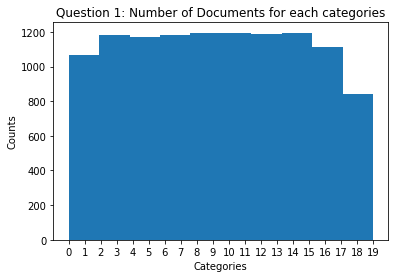

In [5]:
type(newsgroups_train.target)
news_target = newsgroups_train.target
plt.hist(news_target)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(list(range(20)))
plt.title('Question 1: Number of Documents for each categories')
plt.show()

# Question 2

Use the following specs to extract features from the textual data:
• Use the “english” stopwords of the CountVectorizer
• Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
• Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
• Use min_df=3
Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [6]:
np.random.seed(42);
random.seed(42); # do I set the random here
categories = ['comp.graphics', 
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 
              'comp.sys.mac.hardware', 
              'rec.autos', 
              'rec.motorcycles', 
              'rec.sport.baseball', 
              'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None)

In [7]:
# Customize analyzer
analyzer = CountVectorizer().build_analyzer();
# Lemmatizer
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag, in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())
count_vect = CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)

### Training Part

In [8]:
tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tf_idf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tf_idf.shape

(4732, 16600)

### Testing Part

In [9]:
X_test_counts = count_vect.transform(test_dataset.data)
X_test_tf_idf = tfidf_transformer.transform(X_test_counts)
X_test_tf_idf.shape

(3150, 16600)

# Question 3

Reduce the dimensionality of the data using the methods above

• Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector.

• Also reduce dimensionality through NMF (k = 50) and compare with LSI:
Which one is larger, the ∥X − WH∥ F 2 in NMF or the X − U k Σ k V T k F in LSI? Why is the case?

In [10]:
# NMF
## Train
model = NMF(n_components=50, init='random', random_state=0)
NMF_train_reduced = model.fit_transform(X_train_tf_idf)
## Test
NMF_test_reduced = model.transform(X_test_tf_idf)
print("NMF train shape: ", NMF_train_reduced.shape)
print("NMF test shape: ", NMF_test_reduced.shape)

NMF train shape:  (4732, 50)
NMF test shape:  (3150, 50)


In [11]:
H_train = model.components_
NMF_train_val = np.sum(np.array(X_train_tf_idf - NMF_train_reduced.dot(H_train))**2)
NMF_test_val = np.sum(np.array(X_test_tf_idf - NMF_test_reduced.dot(H_train))**2)

In [12]:
print("||X-WH||^2_F Train: ", NMF_train_val)
print("||X-WH||^2_F Test: ", NMF_test_val)

||X-WH||^2_F Train:  3940.5577667857324
||X-WH||^2_F Test:  2691.949309920702


In [13]:
# LSI
## Train
svd = TruncatedSVD(n_components=50, random_state=0)
LSI_train_reduced = svd.fit_transform(X_train_tf_idf)
## Test
LSI_test_reduced = svd.transform(X_test_tf_idf)
print("LSI train shape: ", LSI_train_reduced.shape)
print("LSI test shape: ", LSI_test_reduced.shape)

LSI train shape:  (4732, 50)
LSI test shape:  (3150, 50)


In [14]:
H = svd.components_
## Train
LSI_train_val = np.sum(np.array(X_train_tf_idf - LSI_train_reduced.dot(H))**2)
## Test
LSI_test_val = np.sum(np.array(X_test_tf_idf - LSI_test_reduced.dot(H))**2)

In [15]:
print("||X - USigmaV^T||^2_F Train", LSI_train_val)
print("||X - USigmaV^T||^2_F Test", LSI_test_val)

||X - USigmaV^T||^2_F Train 3895.601668902094
||X - USigmaV^T||^2_F Test 2676.5911826488655


# Question 4

In [16]:
def mergeToBinary(multiClassArray):
    res = np.copy(multiClassArray)
    for i in range(len(multiClassArray)):
        if multiClassArray[i] <= 3:
            res[i] = 0
        else:
            res[i] = 1
    return res

In [17]:
train_labels = mergeToBinary(train_dataset.target)
test_labels = mergeToBinary(test_dataset.target)

In [18]:
%matplotlib inline
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
#     return pipe

def confusionMatrixAndMetrics(ground_truth, predicts):
    conf_matrix = confusion_matrix(ground_truth, predicts)
    preci = precision_score(ground_truth, predicts)
    recall = recall_score(ground_truth, predicts)
    accur = accuracy_score(ground_truth, predicts)
    F1 = 2 / (1/recall + 1/preci)
    print("accura: ", accur)
    print("precision: ", preci)
    print("recall: ", recall)
    print("F1 score: ", F1)
    print ("confusion matrix: \n", conf_matrix)

accura:  0.9612698412698413
precision:  0.9358669833729216
recall:  0.9911949685534591
F1 score:  0.9627367135003053
confusion matrix: 
 [[1452  108]
 [  14 1576]]


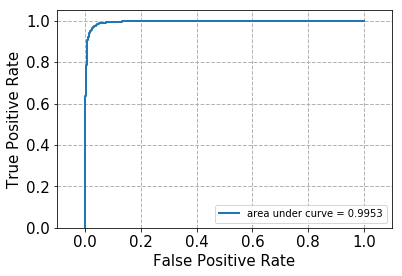

In [19]:
hard_model = LinearSVC(loss='hinge', C=1000)
fit_predict_and_plot_roc(hard_model, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = hard_model.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

accura:  0.5053968253968254
precision:  0.5050825921219823
recall:  1.0
F1 score:  0.671169269734065
confusion matrix: 
 [[   2 1558]
 [   0 1590]]


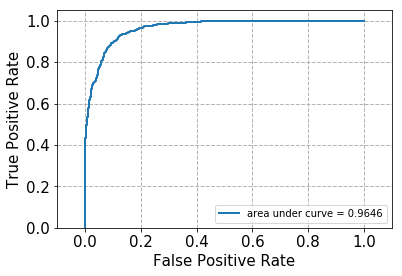

In [20]:
soft_model = LinearSVC(loss='hinge', C=0.0001)
fit_predict_and_plot_roc(soft_model, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = soft_model.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

## Cross Validation

C:  0.001  score:  0.6325352112676057
C:  0.01  score:  0.6328169014084507
C:  0.1  score:  0.9643661971830987
C:  1  score:  0.9738028169014085
C:  10  score:  0.9759154929577466
C:  100  score:  0.975774647887324
C:  1000  score:  0.9749295774647887
Best C:  10
precision:  0.9621588089330024
recall:  0.9754716981132076
F1 score:  0.9687695190505935
confusion matrix: 
 [[1499   61]
 [  39 1551]]


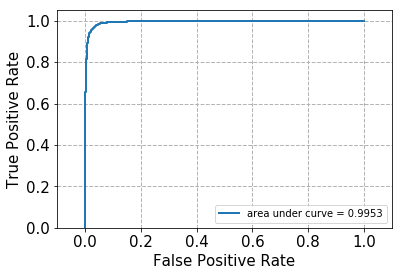

In [20]:
cv = ShuffleSplit(n_splits=5, random_state=0, test_size=0.3)
best_score = -1
best_i = -1;
for i in [-3, -2, -1, 0, 1, 2, 3]:
    clf = LinearSVC(loss='hinge', C=10**i)
    scores = cross_val_score(clf, LSI_train_reduced, train_labels, cv=cv, scoring='accuracy')
    print("C: ", 10**i, " score: ", np.mean(scores))
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_i = i
best_c = 10**best_i
print("Best C: ", best_c)

cv_model = LinearSVC(loss='hinge', C=best_c)
fit_predict_and_plot_roc(cv_model, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = cv_model.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

# Question 5

precision:  0.9628252788104089
recall:  0.9773584905660377
F1 score:  0.9700374531835206
confusion matrix: 
 [[1500   60]
 [  36 1554]]


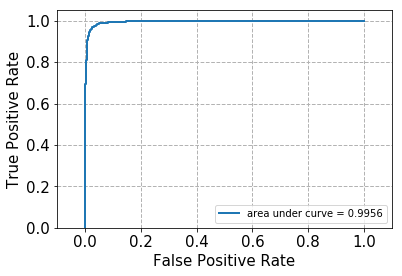

In [41]:
from sklearn.linear_model import LogisticRegression

# approximate logreq without regularization
logreg = LogisticRegression(random_state=0, C = 999999)
fit_predict_and_plot_roc(logreg, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = logreg.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

# Cross Validation for Logistic Regression

In [22]:
# L1 norm regularization
cv = ShuffleSplit(n_splits=5, random_state=0, test_size=0.3)
best_score = -1
best_i = -1;
for i in [-3, -2, -1, 0, 1, 2, 3]:
    clf = LogisticRegression(random_state = 0, penalty = "l1", C=10**i)
    scores = cross_val_score(clf, LSI_train_reduced, train_labels, cv=cv, scoring='accuracy')
    print("C: ", 10**i, " score: ", np.mean(scores))
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_i = i
best_c = 10**best_i
print("Best C: ", best_c)

C:  0.001  score:  0.4954929577464789
C:  0.01  score:  0.4954929577464789
C:  0.1  score:  0.9474647887323944
C:  1  score:  0.9701408450704225
C:  10  score:  0.9774647887323942
C:  100  score:  0.9770422535211267
C:  1000  score:  0.9770422535211267
Best C:  10


precision:  0.9604449938195303
recall:  0.9773584905660377
F1 score:  0.9688279301745637
confusion matrix: 
 [[1496   64]
 [  36 1554]]


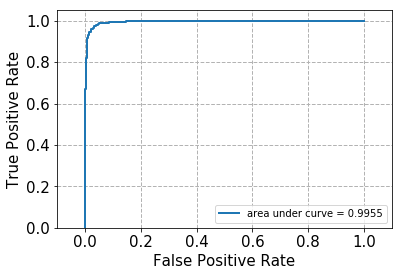

In [23]:
logreg = LogisticRegression(random_state=0, penalty = "l1", C = best_c)
fit_predict_and_plot_roc(logreg, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = logreg.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

In [24]:
# L2 norm regularization
cv = ShuffleSplit(n_splits=5, random_state=0, test_size=0.3)
best_score = -1
best_i = -1;
for i in [-3, -2, -1, 0, 1, 2, 3]:
    clf = LogisticRegression(random_state = 0, penalty = "l2", C=10**i)
    scores = cross_val_score(clf, LSI_train_reduced, train_labels, cv=cv, scoring='accuracy')
    print("C: ", 10**i, " score: ", np.mean(scores))
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_i = i
best_c = 10**best_i
print("Best C: ", best_c)

C:  0.001  score:  0.6919718309859154
C:  0.01  score:  0.9025352112676057
C:  0.1  score:  0.9523943661971831
C:  1  score:  0.9698591549295775
C:  10  score:  0.9753521126760564
C:  100  score:  0.9769014084507044
C:  1000  score:  0.9771830985915495
Best C:  1000


precision:  0.961609907120743
recall:  0.9767295597484277
F1 score:  0.9691107644305773
confusion matrix: 
 [[1498   62]
 [  37 1553]]


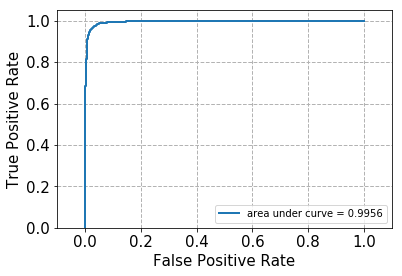

In [25]:
logreg = LogisticRegression(random_state=0, penalty = "l2", C = best_c)
fit_predict_and_plot_roc(logreg, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = logreg.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

# Question 6

In [26]:
from sklearn.naive_bayes import GaussianNB

precision:  0.9026706231454006
recall:  0.9566037735849057
F1 score:  0.9288549618320611
confusion matrix: 
 [[1396  164]
 [  69 1521]]


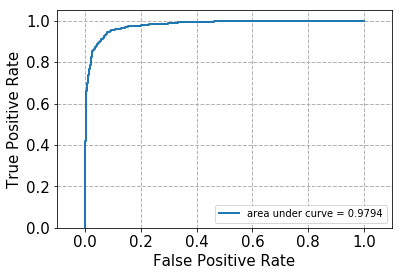

In [27]:
GNB = GaussianNB()
fit_predict_and_plot_roc(GNB, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = GNB.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

# Question 7

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
import pandas as pd


In [37]:
def dumb_stem(doc):
    return (word for word in doc)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
],
memory=memory
)

MIN_DF_OPTIONS = [3, 5]
ANALYZER_OPTIONS = [stem_rmv_punc, dumb_stem]
N_FEATURES_OPTIONS = [50]
C_OPTIONS = [1000]
LOG_REG_PENALTY_OPTIONS = ['l1', 'l2']
# REG_OPTIONS = ['l1', 'l2']
# REG_STRENGTH_OPTIONS = [0.1, 1, 10]

param_grid = [
    {
        'vect__min_df': MIN_DF_OPTIONS,
        'vect__analyzer': ANALYZER_OPTIONS,
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LinearSVC()],
        'clf__C': [100]
    },
    {
        'vect__min_df': MIN_DF_OPTIONS,
        'vect__analyzer': ANALYZER_OPTIONS,
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression()],
        'clf__penalty': ['l1'],
        'clf__C': [10]
    },
    {
        'vect__min_df': MIN_DF_OPTIONS,
        'vect__analyzer': ANALYZER_OPTIONS,
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression()],
        'clf__penalty': ['l2'],
        'clf__C': [1000]
    },
    {
        'vect__min_df': MIN_DF_OPTIONS,
        'vect__analyzer': ANALYZER_OPTIONS,
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [GaussianNB()],
#         'clf__C': C_OPTIONS
    },
]
# reducer_labels = ['LinearSVC', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data, train_dataset.target)



________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x11d3727b8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
[ 'From: dcoleman@utxvms.cc.utexas.edu (Daniel M. Coleman)\n'
  'Subject: Re: MathCad 4.0 swap file\n'
  'Lines: 28\n'
  'Nntp-Posting-Host: blonde.cc.utexas.edu\n'
  'Organization: The University of Texas at Austin\n'
  'Lines: 28\n'
  '\n'
  'In article <1993Apr20.175608.23949@ncar.ucar.edu>, '
  'baseball@catch-the-fever.scd.ucar.edu (Gregg Walters) writes:\n'
  '> I have 16MB of memory on my 386SX.  I have been running Wi

_______________________________________________fit_transform_one - 45.9s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14099 sparse matrix of type '<class 'numpy.int64'>'
	with 428579 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3787x14099 sparse matrix of type '<class 'numpy.float64'>'
	with 428579 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
_______________________________________________

_______________________________________________fit_transform_one - 46.0s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9142 sparse matrix of type '<class 'numpy.int64'>'
	with 411668 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x9142 sparse matrix of type '<class 'numpy.float64'>'
	with 411668 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
________________________________________________f

________________________________________________fit_transform_one - 1.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3784x102 sparse matrix of type '<class 'numpy.int64'>'
	with 249697 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3784x102 sparse matrix of type '<class 'numpy.float64'>'
	with 249697 stored elements in Compressed Sparse Row format>, 
array([6, ..., 2]), None)
________________________________________________fit

________________________________________________fit_transform_one - 1.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3783x98 sparse matrix of type '<class 'numpy.int64'>'
	with 250218 stored elements in Compressed Sparse Row format>, 
array([1, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3783x98 sparse matrix of type '<class 'numpy.float64'>'
	with 250218 stored elements in Compressed Sparse Row format>, 
array([1, ..., 2]), None)
________________________________________________fit_t

________________________________________________fit_transform_one - 1.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3789x98 sparse matrix of type '<class 'numpy.int64'>'
	with 250488 stored elements in Compressed Sparse Row format>, 
array([6, ..., 6]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3789x98 sparse matrix of type '<class 'numpy.float64'>'
	with 250488 stored elements in Compressed Sparse Row format>, 
array([6, ..., 6]), None)
________________________________________________fit_t

_______________________________________________fit_transform_one - 11.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/6d4e136836762321251db6367f92c15b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/ec1be565879022ebf2e46b4d2d58056f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<3785x9142 sparse matrix of type '<class 

________________________________________________fit_transform_one - 3.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e8174ed80ff595e25ac5809
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/387625743df6f0206a916e067e37afc8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<3783x98 sparse matrix of type '<class 'n

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/2a5924cd605af9877e38c83f2b46a74b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b5d5c7ac3ff5d94517c0b0f8cd6d5f36
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/328b9e74215436d0b92bc74ae0f8090f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/926b773eeafb7fb4e2355488285cb02c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/4d7e38c7cb4e38c4b83fdcd5bbc2e430
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5085224ffc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/8c7856282425a9e75a0c2969862f7a02
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/926b773eeafb7fb4e2355488285cb02c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/e07d38b226000161b508b720973ae37e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5085224ffc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/328b9e74215436d0b92bc74ae0f8090f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/926b773eeafb7fb4e2355488285cb02c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/4d7e38c7cb4e38c4b83fdcd5bbc2e430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5085224ffc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/8c7856282425a9e75a0c2969862f7a02
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/926b773eeafb7fb4e2355488285cb02c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/e07d38b226000161b508b720973ae37e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5085224ffc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/328b9e74215436d0b92bc74ae0f8090f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/cac7023af55b4207724ded585d952a3b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/926b773eeafb7fb4e2355488285cb02c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/4d7e38c7cb4e38c4b83fdcd5bbc2e430
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5085224ffc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/43eda7ae83e284d9223dd5e224835ac3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/81460414da9118a5dfc8f010e5cda949
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/8c7856282425a9e75a0c2969862f7a02
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b001a2632e

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=Memory(location=/var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib),
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, m... n_iter=5, random_state=0,
       tol=0.0)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'vect__min_df': [3, 5], 'vect__analyzer': [<function stem_rmv_punc at 0x11d3727b8>, <function dumb_stem at 0x1250aee18>], 'reduce_dim': [TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), NMF(alpha=0.0, beta_loss='frobenius', init=None, l...rbose=0)], 'reduce_dim__n_components': [50], 'clf': [GaussianNB(priors=None, var_smoothing=1e-09)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       

In [38]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_reduce_dim,param_reduce_dim__n_components,param_vect__analyzer,param_vect__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,49.523613,0.653261,11.166323,0.445486,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.849324,0.007954,2,0.879989,0.865222,0.872127,0.869554,0.865664,0.870511,0.005382
1,49.004293,0.801553,11.824415,0.879522,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.846154,0.007786,5,0.868623,0.865751,0.870542,0.866385,0.863025,0.866865,0.002562
2,5.395324,0.036847,0.311407,0.008315,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function dumb_stem at 0x1250aee18>,3,...,0.421598,0.014094,24,0.454137,0.444503,0.452312,0.472934,0.458168,0.456411,0.009379
3,5.384696,0.029471,0.317297,0.015706,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function dumb_stem at 0x1250aee18>,5,...,0.422866,0.010624,21,0.439334,0.442918,0.450462,0.461315,0.443653,0.447536,0.007773
4,15.250289,1.960924,11.249737,0.347329,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.802409,0.007517,10,0.819455,0.810518,0.821136,0.812252,0.819477,0.816568,0.004310
5,11.150645,1.748919,11.427419,0.568630,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.801141,0.002687,11,0.804388,0.820296,0.822721,0.818590,0.819214,0.817042,0.006482
6,6.663390,0.291122,0.939306,0.031179,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function dumb_stem at 0x1250aee18>,3,...,0.416737,0.013848,27,0.439863,0.447146,0.448877,0.453657,0.444444,0.446797,0.004585
7,6.499724,0.069784,0.909073,0.006931,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function dumb_stem at 0x1250aee18>,5,...,0.422443,0.008506,23,0.441713,0.451374,0.446499,0.460523,0.442333,0.448488,0.006941
8,1.001905,0.048179,11.112888,0.459392,"LogisticRegression(C=10, class_weight=None, du...",10,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.850169,0.007778,1,0.881047,0.866543,0.871598,0.873779,0.864608,0.871515,0.005804
9,0.993186,0.038196,11.547454,0.862811,"LogisticRegression(C=10, class_weight=None, du...",10,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.848056,0.007988,4,0.872059,0.868658,0.872127,0.868233,0.864080,0.869031,0.002968


In [39]:
train_dataset_removehf = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None, remove = ("headers", "footers"))
# test_dataset_removehf = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None, remove =  (‘headers’, ‘footers’))
grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset_removehf.data, train_dataset_removehf.target)

rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x11d3727b8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
[ 'Sebastian C Sears, on the Tue, 13 Apr 1993 02:32:13 GMT wibbled:\n'
  '\n'
  ':                  ... Came around a right hand sweeper (going around\n'
  ': \t45 mph) only to find a cager going around 30 mph, calmly driving \n'
  ':       along, with no other traffic around, in *my* lane. Not crossing \n'
  ':       the line, not swerving, fully and totally within the south-bound \n'
  ':       lane of 9W (one lane each dir

_______________________________________________fit_transform_one - 37.3s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x11861 sparse matrix of type '<class 'numpy.int64'>'
	with 339802 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3787x11861 sparse matrix of type '<class 'numpy.float64'>'
	with 339802 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
_______________________________________________

_______________________________________________fit_transform_one - 36.8s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7606 sparse matrix of type '<class 'numpy.int64'>'
	with 325737 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x7606 sparse matrix of type '<class 'numpy.float64'>'
	with 325737 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
________________________________________________f

________________________________________________fit_transform_one - 1.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3784x98 sparse matrix of type '<class 'numpy.int64'>'
	with 202670 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3784x98 sparse matrix of type '<class 'numpy.float64'>'
	with 202670 stored elements in Compressed Sparse Row format>, 
array([4, ..., 2]), None)
________________________________________________fit_t

________________________________________________fit_transform_one - 1.4s, 0.0min
[Memory]1.6s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/8c5916b78e2c7a7b68b24053d5472ca4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1.6s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/33a7c3c80ff9221255b0ad00768d6e9e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function dumb_stem at 0x1250aee18>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
    

________________________________________________fit_transform_one - 1.2s, 0.0min
[Memory]1.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a45e3a6bdc675f63f348a1697b76b3a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/029ce44b5dead13feaef830fb6321fb5
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06

________________________________________________fit_transform_one - 9.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/53932f8678535fe21e167cbf404c718c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f39e3a588c7d98a2778cb9b2e820dfc0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<3785x7606 sparse matrix of type '<class 

________________________________________________fit_transform_one - 3.1s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329be5b39685b770a230729f9c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/8c5916b78e2c7a7b68b24053d5472ca4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d19a5e4219e596c120872ed4f776313c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/2ddfd5b92909288a48549df0afb8b2f2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a45e3a6bdc675f63f348a1697b76b3a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/880b4805049065d4cc173bc4b7af382f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/e2ab3c7826cad97d17aaf209768ded08
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/2ddfd5b92909288a48549df0afb8b2f2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a45e3a6bdc675f63f348a1697b76b3a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/880b4805049065d4cc173bc4b7af382f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/e2ab3c7826cad97d17aaf209768ded08
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/2ddfd5b92909288a48549df0afb8b2f2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a45e3a6bdc675f63f348a1697b76b3a2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/5c8b788975ce91b25ca3c7e6d89da418
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/84aea0b9c51dbf1c918a35516419327c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/880b4805049065d4cc173bc4b7af382f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/b10a0788b8

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/a46470ed02b9553f15bb124c883d5c4f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/d66bc7d5e57919e80c9dc3b03a46b646
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/e2ab3c7826cad97d17aaf209768ded08
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/8d/lf3121w542n2kfb06dvp3ljm0000gn/T/tmpn5frp7ii/joblib/sklearn/pipeline/_fit_transform_one/f43149329b

In [40]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_reduce_dim,param_reduce_dim__n_components,param_vect__analyzer,param_vect__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,39.775156,0.741421,8.988954,0.750386,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.811708,0.003430,1,0.813640,0.829545,0.823514,0.827568,0.826075,0.824069,0.005574
1,39.741396,0.569586,9.058706,0.874013,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.805790,0.009827,5,0.819984,0.827167,0.819022,0.822287,0.824756,0.822643,0.003008
2,5.919895,0.317143,0.280441,0.052456,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function dumb_stem at 0x1250aee18>,3,...,0.416526,0.017791,24,0.455459,0.465381,0.453633,0.439398,0.446820,0.452138,0.008709
3,5.648725,0.207340,0.250241,0.022968,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function dumb_stem at 0x1250aee18>,5,...,0.420118,0.016205,22,0.469469,0.457188,0.443593,0.463692,0.450515,0.456891,0.009187
4,13.004032,1.550663,9.186555,0.721536,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.774091,0.003257,9,0.770288,0.786469,0.794980,0.789807,0.790446,0.786398,0.008499
5,10.416408,1.013940,9.215305,0.794270,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.773035,0.007678,12,0.773989,0.785941,0.793923,0.787959,0.786223,0.785607,0.006483
6,6.351019,0.052877,0.818155,0.017311,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function dumb_stem at 0x1250aee18>,3,...,0.412088,0.016923,28,0.454666,0.448732,0.452048,0.450224,0.463447,0.453823,0.005203
7,5.268100,1.431604,0.822520,0.032987,"LinearSVC(C=100, class_weight=None, dual=True,...",100,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,<function dumb_stem at 0x1250aee18>,5,...,0.420330,0.014659,21,0.452287,0.449789,0.448613,0.460787,0.462127,0.454720,0.005643
8,0.785160,0.050696,8.996995,0.666143,"LogisticRegression(C=10, class_weight=None, du...",10,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,3,...,0.808326,0.008348,3,0.817076,0.833245,0.827741,0.829680,0.825284,0.826605,0.005429
9,0.713665,0.008624,8.982647,0.742182,"LogisticRegression(C=10, class_weight=None, du...",10,"TruncatedSVD(algorithm='randomized', n_compone...",50,<function stem_rmv_punc at 0x11d3727b8>,5,...,0.806213,0.010668,4,0.821835,0.834567,0.822193,0.824399,0.830298,0.826658,0.004982


# Question 8

In [43]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

In [49]:
categories = ["comp.sys.ibm.pc.hardware", 
              "comp.sys.mac.hardware",
              "misc.forsale", 
              "soc.religion.christian"]

new_train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None)
new_test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None)

def confusionMatrixAndMetrics_multi(ground_truth, predicts):
    conf_matrix = confusion_matrix(ground_truth, predicts)
    preci = precision_score(ground_truth, predicts, average = "weighted")
    recall = recall_score(ground_truth, predicts, average = "weighted")
    F1 = 2 / (1/recall + 1/preci)
    print("precision: ", preci)
    print("recall: ", recall)
    print("F1 score: ", F1)
    print ("confusion matrix: \n", conf_matrix)

def multi_clf_pipeline(model, train_dataset, test_dataset):
    print(model)
    pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=3, stop_words='english', analyzer = stem_rmv_punc)),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(random_state=0, n_components = 50)),
        ('clf', model),
        ]
    )
    pipeline.fit(train_dataset.data, train_dataset.target)
    predicts = pipeline.predict(test_dataset.data)
    confusionMatrixAndMetrics_multi(test_dataset.target, predicts)
    

multi_clf_pipeline(OneVsOneClassifier(LinearSVC(C=100, random_state=42)), new_train_dataset, new_test_dataset)
multi_clf_pipeline(OneVsRestClassifier(LinearSVC(C=100, random_state=42)), new_train_dataset, new_test_dataset)
multi_clf_pipeline(OneVsOneClassifier(GaussianNB()), new_train_dataset, new_test_dataset)
multi_clf_pipeline(OneVsRestClassifier(GaussianNB()), new_train_dataset, new_test_dataset)


OneVsOneClassifier(estimator=LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
          n_jobs=None)
precision:  0.8780649488448964
recall:  0.8779552715654952
F1 score:  0.8780101067800914
confusion matrix: 
 [[314  54  21   3]
 [ 44 320  21   0]
 [ 18  20 349   3]
 [  1   2   4 391]]
OneVsRestClassifier(estimator=LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
          n_jobs=None)
precision:  0.8780060062902052
recall:  0.8779552715654952
F1 score:  0.8779806381949148
confusion matrix: 
 [[309  62  18   3]
 [ 42 318  23   2]
 [ 18  16 355   1]
 [  1   3   2 392]]
OneVsOneClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          n_jobs=Non